<a href="https://colab.research.google.com/github/khushishelat/GenderBiasSportsJournalism/blob/Kyle/Tennis_data_EDA_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
!pip install gitpython

In [ ]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from copy import deepcopy
from string import punctuation
from random import randint
import numpy as np
from PIL import Image
from git import Repo
from pathlib import Path
from nltk.stem.snowball import SnowballStemmer

In [ ]:
cities_df = pd.read_csv('/content/world-cities.csv')
names_df = pd.read_csv('/content/players.csv')
states_df = pd.read_csv('/content/states.csv')
state_names_df = pd.read_csv('/content/StateNames.csv')
nat_names_df = pd.read_csv('/content/NationalNames.csv')

In [ ]:
questions_df = pd.read_json('questions_matchinfo.json', orient='index')
commentaries_df = pd.read_json('text_commentaries.json')
transcripts_df = pd.read_json('transcripts_matchinfo.json', orient='index')

# Helper Functions / Background Computations

In [ ]:
# get word valence, arousal, and dominance scores dataframe
def get_xanew(root=Path.home()/'data/X-ANEW',
              url = 'https://github.com/JULIELab/X-ANEW.git'):

    # if not root.is_dir():
    #     root.mkdir()
    #     print('Downloading the dataset from github...')
    #     Repo.clone_from(url, str(root))

    csv = str(root / 'Ratings_Warriner_et_al.csv')
    df = pd.read_csv(csv, index_col=0)
    df=df[['Word','V.Mean.Sum', 'A.Mean.Sum', 'D.Mean.Sum']]
    df.columns=['word', 'valence', 'arousal', 'dominance']
    df.set_index('word',inplace=True)

    return df


# downloads the dataset if necessary and returns a pandas DataFrame
vad_word_df = get_xanew()
vad_word_df

valence  arousal  dominance
word                                    
aardvark        6.26     2.41       4.27
abalone         5.30     2.65       4.95
abandon         2.84     3.73       3.32
abandonment     2.63     4.95       2.64
abbey           5.85     2.20       5.00
...              ...      ...        ...
zone            4.75     3.78       5.23
zoning          4.65     3.77       4.47
zoo             7.00     5.63       6.33
zoom            5.86     5.68       5.90
zucchini        6.30     4.18       6.19

[13915 rows x 3 columns]

In [ ]:
cities_df['cities'] = cities_df['name'].apply(lambda x: x.lower())
cities_df['country'] = cities_df['country'].apply(lambda x: x.lower())
cities_df['subcountry'] = cities_df['subcountry'].apply(lambda x: str(x).lower())

states_df['cities'] = states_df['Cities'].apply(lambda x: str(x).lower())
states_df['states'] = states_df['States'].apply(lambda x: str(x).lower())

state_names_df['Name'] = state_names_df['Name'].apply(lambda x: str(x).lower())
nat_names_df['Name'] = nat_names_df['Name'].apply(lambda x: str(x).lower())

names_df['first_name'] = names_df['first_name'].apply(lambda x: str(x).lower())
names_df['last_name'] = names_df['last_name'].apply(lambda x: str(x).lower())


for p in punctuation:
  cities_df['cities'] = cities_df['cities'].apply(lambda x: str(x).replace(p, ''))
  cities_df['country'] = cities_df['country'].apply(lambda x: str(x).replace(p, ''))
  cities_df['subcountry'] = cities_df['subcountry'].apply(lambda x: str(x).replace(p, ''))
  states_df['cities'] = states_df['Cities'].apply(lambda x: str(x).replace(p, ''))
  states_df['states'] = states_df['States'].apply(lambda x: str(x).replace(p, ''))
  state_names_df['Name'] = state_names_df['Name'].apply(lambda x: str(x).replace(p, ''))
  nat_names_df['Name'] = nat_names_df['Name'].apply(lambda x: str(x).replace(p, ''))
  names_df['first_name'] = names_df['first_name'].apply(lambda x: str(x).replace(p, ''))
  names_df['last_name'] = names_df['last_name'].apply(lambda x: str(x).replace(p, ''))


cities = list(set(cities_df['cities'].to_list()))
countries = list(set(cities_df['country'].to_list()))
subcountries = list(set(cities_df['subcountry'].to_list()))
us_cities = list(set(states_df['cities'].to_list()))
us_states = list(set(states_df['states'].to_list()))
state_names = list(set(state_names_df['Name'].to_list()))
nat_names = list(set(nat_names_df['Name'].to_list()))
first_names = list(set(names_df['first_name'].to_list()))
last_names = list(set(names_df['last_name'].to_list()))


names = []
names.extend(first_names)
names.extend(last_names)
names = list(set(names))
names.extend(state_names)
names = list(set(names))
names.extend(nat_names)
names = list(set(names))

locations = []
locations.extend(cities)
locations.extend(us_cities)
locations = list(set(locations))
locations.extend(us_states)
locations.extend(countries)
locations.extend(subcountries)
locations = list(set(locations))

In [ ]:
contractions = ["we're", "you're", "they're", "there's", "haven't", "doesn't",
                "must've", "could've", "should've", "might've", "wouldn't",
                "couldn't", "would've", "can't", "won't", "isn't", "wasn't",
                "he's", "she's", "he'll", "she'll", "he'd", "she'd", "they've",
                "they'll", "they'd"]

symbols = "',.()!?\"\\/"

questions_words = ' '.join(questions_df.explode(column='questions')['questions']).split()
commentary_words = ' '.join(commentaries_df.explode(column='commentary')['commentary']).split()

my_ques_df = pd.DataFrame(questions_words, columns =['words'])
my_comm_df = pd.DataFrame(commentary_words, columns =['words'])

# make lowercase
my_ques_df['words'] = my_ques_df['words'].apply(lambda x: x.lower())
my_comm_df['words'] = my_comm_df['words'].apply(lambda x: x.lower())

# remove ending punctuation
my_ques_df['words'] = my_ques_df['words'].apply(lambda x: x[0:-1] if x[-1] in symbols else x)
my_comm_df['words'] = my_comm_df['words'].apply(lambda x: x[0:-1] if x[-1] in symbols else x)

# remove punctuation
for p in punctuation:
  my_ques_df['words'] = my_ques_df['words'].apply(lambda x: x.replace(p, '') if x not in contractions else x)
  my_comm_df['words'] = my_comm_df['words'].apply(lambda x: x.replace(p, '') if x not in contractions else x)

# remove duplicates
questions_words = list(set(my_ques_df['words'].to_list()))
commentary_words = list(set(my_comm_df['words'].to_list()))

answers = []
for interview in transcripts_df['QandA'].to_list():
  for qna in interview:
    answers.append(qna[1])

split_words = [words.split() for words in answers]
answers_words = []
for words in split_words:
  for word in words:
    word = word.lower()
    if word[-1] in symbols:
      word = word[0:-1]
    if word not in contractions:
      for p in punctuation:
        word = word.replace(p, '')
    answers_words.append(word)

all_words = []
all_words.extend(list(set(questions_words)))
all_words.extend(list(set(commentary_words)))
all_words.extend(list(set(answers_words)))
all_words = list(set(all_words))

In [ ]:
# Get list of names and gender specific words to remove during EDA

# Explode Questions column
questions_df_cleaned = questions_df.explode(column='questions')
commentaries_df_cleaned = commentaries_df.explode(column='commentary')
transcripts_df_cleaned = transcripts_df.explode(column='QandA')


# gender specific words, country-related words, and previous players
manual_remove_words = ['he', 'him', 'his', 'she', 'her', 'hers', "he's", "she's",
                       "he'll", "she'll", "he'd", "she'd", 'man', 'men', 'mens',
                       'woman', 'women', 'womens', 'guy', 'girl', 'guys',
                       'girls', 'male', 'female', 'himself', 'herself',
                       'serenas', 'boris', 'agassi', 'sampras', 'del', 'potro',
                       'atp', 'wta', 'fed', 'agut', 'frenchman', 'swiss',
                       'serb', 'serbian', 'russian', 'french', 'american',
                       'australian', 'canadian', 'spanish', 'spaniard', 'scot',
                       'belarusian', 'brit', 'italian', 'german', 'english',
                       'murrays', 'one', 'two', 'three', 'four', 'five', 'six',
                       'seven', 'eight', 'nine', 'ten', 'japan', 'japanese',
                       'china', 'chinese', 'first', 'second', 'third', 'fourth',
                       'fifth', 'sixth', 'seventh', 'eighth', 'ninth', 'tenth',
                       'london', 'shanghai', 'montecarlo', 'wuhan', 'queens',
                       'melbourne', 'singapore', 'eastbourne', 'york', 'polish',
                       'israel', 'florida', 'pole', 'onetwo', 'andre', 'pete',
                       'dubai', 'istanbul', 'australia', 'vika', 'mcenroe',
                       'barcelona', 'sydney', 'madrid', 'brad', 'jo', 'doha',
                       'england', 'lendl', 'nigel', 'borg', 'gonzlez', 'steffi',
                       'america', 'bernie', 'billie', 'charleston', 'switzerland',
                       'stuttgart', 'aga', 'bestofthree', 'jimmy', 'connors',
                       'jean', 'spain', 'south', 'africa', 'russia', 'germany',
                       'flipkens', 'birmingham', 'twosetter', 'twoset',
                       'threesetter', 'threeset', 'foursetter', 'fourset',
                       'fivesetter', 'fiveset', 'graf', 'laver', 'navratilova',
                       'tony', 'moscow', 'stefan', 'italy', 'ashe', 'evert',
                       'genie', 'romania', 'goran', 'washington', 'cincinnati',
                       'belgium', 'bercy', 'sugarpova', 'montreal', 'toronto',
                       'halle', 'stanford', 'seles', 'hobart', 'san', 'diego',
                       'los', 'angeles', 'york', 'poland', 'achale', 'kooyong',
                       'sunday', 'monday', 'tuesday', 'wednesday', 'thursday',
                       'friday', 'saturday', 'georgia', 'argentina', 'hanburg',
                       'sven', 'california', 'casse', 'etienne', 'federernadal',
                       'gracialopez', 'caas', 'magnus', 'pattaya', 'courier',
                       'turkish', 'loydra', 'sasha', 'petko', 'chernobyl',
                       'rafa', 'llodra', 'knowles', 'fifthset', 'williamses',
                       'golubev', 'shell', 'hogstedt', 'allaster', 'annacone',
                       'dhabi', 'piatti', 'allwilliams', 'ncaas', 'ncaa',
                       'shoaxuan', 'swedes', 'supersaturday', 'ponte',
                       'belgians', 'belgian', 'stanislas', 'puerto', 'twohour',
                       'roig', 'matsuoka', 'garcialopez', 'ukrainian',
                       'frenchwoman', 'djoko', 'greek', 'belorussian', 'muzza',
                       'makarvoa', 'zealander', 'berydch', 'wellexecuted',
                       'highquality', 'delpo', 'lpez', 'portuguese', 'rola',
                       'croat', 'dutchman', 'dutchwoman', 'chinatown',
                       'allrussian', 'duval', 'ghangzou', 'romanians',
                       'brazilian', 'swedish', "they've", "they're", "they's",
                       "they'll", "they'd", "there's", "you", "your", "you're",
                       "there"]


"""player names from the data (questions and interviews dataframes)"""

# make lowercase
questions_df_cleaned['player'] = questions_df_cleaned['player'].apply(lambda x: x.lower())
transcripts_df['player'] = transcripts_df['player'].apply(lambda x: x.lower())
transcripts_df['opponent'] = transcripts_df['opponent'].apply(lambda x: x.lower())

# remove ending punctuation
questions_df_cleaned['player'] = questions_df_cleaned['player'].apply(lambda x: str(x)[0:-1] if str(x)[-1] in symbols else str(x))
transcripts_df['player'] = transcripts_df['player'].apply(lambda x: str(x)[0:-1] if str(x)[-1] in symbols else str(x))
transcripts_df['opponent'] = transcripts_df['opponent'].apply(lambda x: str(x)[0:-1] if str(x)[-1] in symbols else str(x))

# remove punctation
for p in punctuation:
    questions_df_cleaned['player'] = questions_df_cleaned['player'].apply(lambda x: str(x).replace(p, '') if str(x) not in contractions else x)
    transcripts_df['player'] = transcripts_df['player'].apply(lambda x: str(x).replace(p, '') if str(x) not in contractions else x)
    transcripts_df['opponent'] = transcripts_df['opponent'].apply(lambda x: str(x).replace(p, '') if str(x) not in contractions else x)

# remove duplicates
q_players = list(set(questions_df_cleaned['player'].to_list()))
a_players = list(set(transcripts_df['player'].to_list()))
a_opp_players = list(set(transcripts_df['opponent'].to_list()))

# get first/last names
q_first_names = [player.split()[0] if len(player.split()) > 1 else player.split()[0] for player in q_players]
q_last_names = [player.split()[1] for player in q_players]
a_first_names = [player.split()[0] for player in a_players]
a_last_names = [player.split()[1] for player in a_players]
a_opp_first_names = [player.split()[0] for player in a_opp_players]
a_opp_last_names = [player.split()[1] if len(player.split()) > 1 else player.split()[0] for player in a_opp_players]

# remove duplicates
q_first_names = list(set(q_first_names))
q_last_names = list(set(q_last_names))
a_first_names = list(set(a_first_names))
a_last_names = list(set(a_last_names))
a_opp_first_names = list(set(a_opp_first_names))
a_opp_last_names = list(set(a_opp_last_names))

# combine names and gender specific words into one list of words to be removed
remove_words = manual_remove_words + q_first_names + q_last_names + a_first_names + a_last_names + a_opp_first_names + a_opp_last_names + names + locations
remove_words = list(set(remove_words))

# get intersection of remove words and all words
removed_words = list(set(all_words) & set(remove_words))
removed_words_df = pd.DataFrame(removed_words, columns =['words'])

# save the removed words to a dataframe for later use
removed_words_df.to_csv('removed_words.zip', index=False,
          compression=dict(method='zip', archive_name='removed_words.csv')  )

In [ ]:
# function to get words occurring disproportionately with males and females
def get_diff_words(male_words, female_words, remove_words, n_stds,
                   graph_name=None):

  Counter(male_words)

  # lowercase words and remove punctuation
  male_words_cleaned = []
  female_words_cleaned = []

  for pair in Counter(male_words).most_common():
    m_word = pair[0].lower()
    m_count = pair[1]
    if m_word[-1] in symbols:
      m_word = m_word[0:-1]
    if m_word in contractions:
      if (m_word not in removed_words) and (m_word[0:-1] not in removed_words):
          male_words_cleaned.extend([m_word for _ in range(m_count)])
    else:
      if not set(m_word).intersection('0123456789'):
        for p in punctuation:
          m_word = m_word.replace(p, '')
        if (m_word not in removed_words) and (m_word[0:-1] not in removed_words):
          male_words_cleaned.extend([m_word for _ in range(m_count)])

  for pair in Counter(female_words).most_common():
    f_word = pair[0].lower()
    f_count = pair[1]
    if f_word[-1] in symbols:
      f_word = f_word[0:-1]
    if f_word in contractions:
      if (f_word not in removed_words) and (f_word[0:-1] not in removed_words):
          female_words_cleaned.extend([f_word for _ in range(f_count)])
    else:
      if not set(f_word).intersection('0123456789'):
        for p in punctuation:
          f_word = f_word.replace(p, '')
        if (f_word not in removed_words) and (f_word[0:-1] not in removed_words):
          female_words_cleaned.extend([f_word for _ in range(f_count)])

  # rename cleaned list
  male_words = male_words_cleaned
  female_words = female_words_cleaned

  # get list of male and female word count tuples
  male_word_counts = list(dict(Counter(male_words)).values())
  female_word_counts = list(dict(Counter(female_words)).values())

  # get respective desired cutoffs for number of standard deviations above mean
  male_freq_cutoff = n_stds*np.std(male_word_counts) + np.mean(male_word_counts)
  female_freq_cutoff = n_stds*np.std(female_word_counts) + np.mean(female_word_counts)

  if graph_name:
    # print means and standard deviations
    print('-------------------------------------------------------------------')
    print("Male Frequency Mean:", np.mean(male_word_counts))
    print("Female Frequency Mean:", np.mean(female_word_counts))
    print("Male Frequency STD:", np.std(male_word_counts))
    print("Female Frequency STD:", np.std(female_word_counts))
    print('-------------------------------------------------------------------')

  """Remove words that appear in both the mens and womens question data and
  appear a certain number of standard deviations above the mean frequency in
  the combined data set."""

  # get male, female, and an intersection Counters
  male_counter = Counter(male_words)
  female_counter = Counter(female_words)

  # get male/female (word, count) tuple lists and list of intersection words
  male_word_count_list = male_counter.most_common()
  female_word_count_list = female_counter.most_common()

  # get list of intersection words that appear more often than the
  #    designated cutoff
  male_top_inter_list = [i[0] for i in male_word_count_list
                        if i[1] > male_freq_cutoff]

  female_top_inter_list = [i[0] for i in female_word_count_list
                          if i[1] > female_freq_cutoff]

  # take the intersection of the male/female intersection lists
  top_inter_list = list(set(male_top_inter_list) & set(female_top_inter_list))

  # create reduced male and female words lists by removing these high frequency
  #    intersection words
  male_words_red = [[pair[0] for _ in range(pair[1])] for pair in male_word_count_list if pair[0] not in top_inter_list]
  female_words_red = [[pair[0] for _ in range(pair[1])] for pair in female_word_count_list if pair[0] not in top_inter_list]
  male_words_red = [word for sublst in male_words_red for word in sublst]
  female_words_red = [word for sublst in female_words_red for word in sublst]

  # get difference in male and female word lengths
  length_diff = len(male_words_red) - len(female_words_red)

  # randomly remove words from bigger list until both are the same size
  if length_diff > 0:
    for _ in range(length_diff):
      male_words_red.pop(randint(0, len(male_words_red)-1))
  else:
    for _ in range(-length_diff):
      female_words_red.pop(randint(0, len(female_words_red)-1))

  # get counts of reduced lists
  male_counter_red = Counter(male_words_red)
  female_counter_red = Counter(female_words_red)

  if graph_name:
    # print sizes of each list to make sure they match
    print('Male Word Count:', male_counter_red.total())
    print('Female Word Count:', female_counter_red.total())
    print('-------------------------------------------------------------------')

  """Time to get the differences when subtracting each of the counts from
  the other."""

  # copy male and female counters
  male_diff_counter = deepcopy(male_counter_red)
  female_diff_counter = deepcopy(female_counter_red)

  # subtract each from the other to get the difference in counts
  male_diff_counter.subtract(female_counter_red)
  female_diff_counter.subtract(male_counter_red)

  # get male and female elements from these words more associated with each
  male_elements = sorted(male_diff_counter.elements())
  female_elements = sorted(female_diff_counter.elements())

  # get male and female diff lists of tuple (word, counts)
  male_diff_list = male_diff_counter.most_common()
  female_diff_list = female_diff_counter.most_common()

  if graph_name:

    """Create word clouds for the male/female results"""

    # male world cloud
    male_mask = np.array(Image.open("/content/male_symbol.jpg"))
    male_wordcloud = WordCloud(width=10, height=15, mask=male_mask,
                          background_color='navy').fit_words(dict(male_diff_list))

    # female world cloud
    female_mask = np.array(Image.open("/content/female_symbol.jpg"))
    female_wordcloud = WordCloud(width=10, height=15, mask=female_mask,
                          background_color='pink').fit_words(dict(female_diff_list))

    # Display the generated word cloud using matplotlib
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,10))
    ax1.imshow(male_wordcloud.recolor(color_func=male_color_func, random_state=3), interpolation='bilinear')
    ax2.imshow(female_wordcloud.recolor(color_func=female_color_func, random_state=3), interpolation='bilinear')
    ax1.axis('off')
    ax2.axis('off')
    ax1.set_title("Disproportionately Male-Occurring Words", fontsize = 12)
    ax2.set_title("Disproportionately Female-Occurring Words", fontsize = 12)
    if n_stds:
      fig.suptitle(str(graph_name) + " Word Clouds by Gender\n(removed intersection words with freq above {} stds)".format(n_stds), fontsize = 22)
    else:
      fig.suptitle(str(graph_name) + " Word Clouds by Gender\n(removed intersection words with freq above the mean)", fontsize = 22)

  return (male_elements, female_elements), (male_counter_red, female_counter_red), (male_diff_list, female_diff_list)

In [ ]:
def get_avg_vad(male_words, female_words, remove_words, n_stds, graph_name=None):

  elements = get_diff_words(male_words, female_words, remove_words, n_stds)[0]
  stemmer = SnowballStemmer("english")

  output_lst = []
  print('-------------------------------------------------------------------')
  for i, lst in enumerate(elements):
    valence = []
    arousal = []
    dominance = []
    words_included = []
    words_excluded = []
    for word in lst:
      if word in vad_word_df.index:
        valence.append(vad_word_df.loc[word]['valence'])
        arousal.append(vad_word_df.loc[word]['arousal'])
        dominance.append(vad_word_df.loc[word]['dominance'])
        words_included.append(word)
      elif len(word) > 1 and word[-1] == 's' and word[0:-1] in vad_word_df.index:
        word = word[0:-1]
        valence.append(vad_word_df.loc[word]['valence'])
        arousal.append(vad_word_df.loc[word]['arousal'])
        dominance.append(vad_word_df.loc[word]['dominance'])
        words_included.append(word)
      elif len(word) > 1 and word[-1] == 'y' and word[0:-1] in vad_word_df.index:
        word = word[0:-1]
        valence.append(vad_word_df.loc[word]['valence'])
        arousal.append(vad_word_df.loc[word]['arousal'])
        dominance.append(vad_word_df.loc[word]['dominance'])
        words_included.append(word)
      elif len(word) > 2 and word[-2:] == 'ed' and word[0:-2] in vad_word_df.index:
        word = word[0:-2]
        valence.append(vad_word_df.loc[word]['valence'])
        arousal.append(vad_word_df.loc[word]['arousal'])
        dominance.append(vad_word_df.loc[word]['dominance'])
        words_included.append(word)
      elif len(word) > 2 and word[-2:] == 'er' and word[0:-2] in vad_word_df.index:
        word = word[0:-2]
        valence.append(vad_word_df.loc[word]['valence'])
        arousal.append(vad_word_df.loc[word]['arousal'])
        dominance.append(vad_word_df.loc[word]['dominance'])
        words_included.append(word)
      elif len(word) > 2 and word[-2:] == 'ly' and word[0:-2] in vad_word_df.index:
        word = word[0:-2]
        valence.append(vad_word_df.loc[word]['valence'])
        arousal.append(vad_word_df.loc[word]['arousal'])
        dominance.append(vad_word_df.loc[word]['dominance'])
        words_included.append(word)
      elif len(word) > 2 and word[-2:] == 'es' and word[0:-2] in vad_word_df.index:
        word = word[0:-2]
        valence.append(vad_word_df.loc[word]['valence'])
        arousal.append(vad_word_df.loc[word]['arousal'])
        dominance.append(vad_word_df.loc[word]['dominance'])
        words_included.append(word)
      elif len(word) > 3 and word[-3:] == 'ing' and word[0:-3] in vad_word_df.index:
        word = word[0:-3]
        valence.append(vad_word_df.loc[word]['valence'])
        arousal.append(vad_word_df.loc[word]['arousal'])
        dominance.append(vad_word_df.loc[word]['dominance'])
        words_included.append(word)
      elif len(word) > 3 and word[-3:] == 'ity' and word[0:-3] in vad_word_df.index:
        word = word[0:-3]
        valence.append(vad_word_df.loc[word]['valence'])
        arousal.append(vad_word_df.loc[word]['arousal'])
        dominance.append(vad_word_df.loc[word]['dominance'])
        words_included.append(word)
      elif len(word) > 3 and word[-3:] == 'ery' and word[0:-3] in vad_word_df.index:
        word = word[0:-3]
        valence.append(vad_word_df.loc[word]['valence'])
        arousal.append(vad_word_df.loc[word]['arousal'])
        dominance.append(vad_word_df.loc[word]['dominance'])
        words_included.append(word)
      elif len(word) > 3 and word[-3:] == 'ant' and word[0:-3] in vad_word_df.index:
        word = word[0:-3]
        valence.append(vad_word_df.loc[word]['valence'])
        arousal.append(vad_word_df.loc[word]['arousal'])
        dominance.append(vad_word_df.loc[word]['dominance'])
        words_included.append(word)
      elif len(word) > 3 and word[-3:] == 'ism' and word[0:-3] in vad_word_df.index:
        word = word[0:-3]
        valence.append(vad_word_df.loc[word]['valence'])
        arousal.append(vad_word_df.loc[word]['arousal'])
        dominance.append(vad_word_df.loc[word]['dominance'])
        words_included.append(word)
      elif len(word) > 4 and word[-4:] == 'ness' and word[0:-4] in vad_word_df.index:
        word = word[0:-4]
        valence.append(vad_word_df.loc[word]['valence'])
        arousal.append(vad_word_df.loc[word]['arousal'])
        dominance.append(vad_word_df.loc[word]['dominance'])
        words_included.append(word)
      elif len(word) > 4 and word[-4:] == 'ment' and word[0:-4] in vad_word_df.index:
        word = word[0:-4]
        valence.append(vad_word_df.loc[word]['valence'])
        arousal.append(vad_word_df.loc[word]['arousal'])
        dominance.append(vad_word_df.loc[word]['dominance'])
        words_included.append(word)
      elif len(word) > 4 and word[-4:] == 'ship' and word[0:-4] in vad_word_df.index:
        word = word[0:-4]
        valence.append(vad_word_df.loc[word]['valence'])
        arousal.append(vad_word_df.loc[word]['arousal'])
        dominance.append(vad_word_df.loc[word]['dominance'])
        words_included.append(word)
      elif stemmer.stem(word) in vad_word_df:
        word = stemmer.stem(word)
        valence.append(vad_word_df.loc[word]['valence'])
        arousal.append(vad_word_df.loc[word]['arousal'])
        dominance.append(vad_word_df.loc[word]['dominance'])
        words_included.append(word)
      else:
        words_excluded.append(word)
    output_lst.append((valence, arousal, dominance))

    if i:
      name = "Female"
    else:
      name = "Male"
    print(name + " Percentage of Words Included:", round(len(words_included) /
                                                    (len(words_included) +
                                                    len(words_excluded)), 2))
    print('-------------------------------------------------------------------')

    if not graph_name:
      print(name + " Average Valence:", round(np.mean(valence), 2))
      print(name + " Average Arousal:", round(np.mean(arousal), 2))
      print(name + " Average Dominance:", round(np.mean(dominance), 2))


  if graph_name:

    combined_v = output_lst[0][0] + output_lst[1][0]
    combined_a = output_lst[0][1] + output_lst[1][1]
    combined_d = output_lst[0][2] + output_lst[1][2]
    combined_vad_scores = combined_v + combined_a + combined_d
    combined_vad_labels = ['valence' for _ in range(len(combined_v))] + ['arousal' for _ in range(len(combined_a))] + ['dominance' for _ in range(len(combined_d))]
    combined_g = 3*(['M' for _ in range(len(output_lst[0][0]))] + ['F' for _ in range(len(output_lst[1][0]))])

    df = pd.DataFrame(list(zip(combined_vad_labels, combined_vad_scores, combined_g)),
                columns=['label', 'score', 'gender'])

    # create custom colors array
    colors = ["#001ba1", "#fc90ab"]
    # set custom color palette
    sns.set_palette(sns.color_palette(colors))

    ax = sns.barplot(data=df, x='label', y='score',
                    hue='gender', dodge=True, hue_order=['M', 'F'],
                    estimator="mean", errorbar=None)

    ax.bar_label(ax.containers[0], fmt='%.2f', fontsize=10);
    ax.bar_label(ax.containers[1], fmt='%.2f', fontsize=10);

    # Adding labels and title
    plt.xlabel('Word Characteristics', fontsize=12)
    plt.ylabel('Mean Characteristic Score', fontsize=12)
    if n_stds:
      plt.title(str(graph_name) + " Mean Word Characteristic Scores by Gender\n(removed intersection words with freq above {} stds)".format(n_stds), fontsize = 15)
    else:
      plt.title(str(graph_name) + " Mean Word Characteristic Scores by Gender\n(removed intersection words with freq above the mean)", fontsize = 15)

    # Adding a legend
    plt.legend()

    # Display the plot
    plt.show()

  return output_lst

In [ ]:
# Make male/female color functions
def female_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(230, 100%%, %d%%)" % randint(20, 50)

def male_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(5, 55%%, %d%%)" % randint(70, 100)

# Exploring dataframes

Files
-----

* *questions_matchinfo.json* - a JSON file containing the press conference question snippets together with player ranking and game result.
* *transcripts_matchinfo.json* - a JSON file containing full transcripts with more complete match information.
* *text_commentaries.json* - a JSON file containing commentary data.

In [ ]:
questions_df.head()

player gender  result  \
0     Andy Murray      M       1   
1  Kevin Anderson      M       0   
2  Kevin Anderson      M       1   
3    Gilles Simon      M       1   
4    Milos Raonic      M       0   

                                           questions  ranking  
0  [That last set seemed like a faultless perform...      3.0  
1  [What was it like out there, Kevin?, That was ...     17.0  
2  [You were saying courtside you haven't done an...     17.0  
3  [Big serving has been sort of the theme for th...     13.0  
4  [How disappointing is that loss for you?, When...      8.0

In [ ]:
commentaries_df.head()

commentary  \
0  Makarova slumps back into making unforced erro...   
1  Just look in her match with Heather Watson las...   
2  Sharapova saves a break point to hold her serv...   
3  Erakovic is looking superb behind her serve, a...   
4  She can't save another one and Williams is now...   

                    scoreline gender  
0     Sharapova 6-3* Makarova      F  
1  Williams 3-6 2-1* Azarenka      F  
2     Williams *0-2 Sharapova      F  
3        Robson 1-4* Erakovic      F  
4   Williams 2-6 5-1* Lisicki      F

In [ ]:
transcripts_df.head()

QandA  ranking tournament_type  \
0  [[That last set seemed like a faultless perfor...      3.0          ATP500   
1  [[What was it like out there, Kevin?, It was t...     17.0          ATP500   
2  [[You were saying courtside you haven't done a...     17.0          ATP500   
3  [[Big serving has been sort of the theme for t...     13.0          ATP500   
4  [[How disappointing is that loss for you?, The...      8.0          ATP500   

  gender           tournament          player  result       date  \
0      M  AEGON CHAMPIONSHIPS     andy murray       1 2015-06-21   
1      M  AEGON CHAMPIONSHIPS  kevin anderson       0 2015-06-21   
2      M  AEGON CHAMPIONSHIPS  kevin anderson       1 2015-06-20   
3      M  AEGON CHAMPIONSHIPS    gilles simon       1 2015-06-19   
4      M  AEGON CHAMPIONSHIPS    milos raonic       0 2015-06-19   

           stage        opponent  
0      The Final  kevin anderson  
1      The Final     andy murray  
2     Semifinals    gilles simon  
3  Quarterfinals    milos raonic  
4  Quarterfinals    gilles simon

## Questions Data

Post-match press conferences in tennis take place shortly after each match. Players enter a press conference room to face a group of reporters from different news agencies and answer questions posed to them.

This file contains a slightly processed version of the transcript data which we use in our study. It covers a total of 6467 post-match press conferences. Duplicate questions from the same interview are removed.

It is in the form of a JSON file with five fields:
- 'gender': player gender
- 'player': name of the player being interviewed
- 'questions': list of question snippets asked in the press conference. Each entry represents one turn from one reporter.
- 'ranking': ranking of the player
- 'result': 1 indicates the player being interviewed is the match winner; 0 otherwise.

For the full transcript and more complete match information, refer to the transcript data described below.


In [ ]:
questions_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6467 entries, 0 to 6466
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   player     6467 non-null   object 
 1   gender     6467 non-null   object 
 2   result     6467 non-null   int64  
 3   questions  6467 non-null   object 
 4   ranking    6466 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 303.1+ KB


### All Question Data Word Cloud

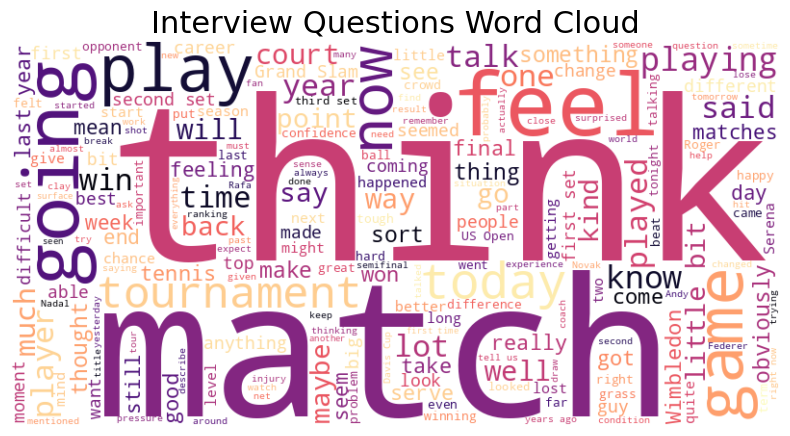

In [ ]:
# All Questions Word Cloud
text = ' '.join(questions_df_cleaned['questions'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400,
                      colormap=sns.color_palette("magma", as_cmap=True),
                      background_color='white').generate(text)

# Display the generated word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Interview Questions Word Cloud', fontsize = 22)
plt.show()

### Gender Specific Question Data Word Clouds

In [ ]:
# filter into mens and womens data
questions_m_df_cleaned = questions_df_cleaned[questions_df_cleaned['gender'] == 'M']
questions_f_df_cleaned = questions_df_cleaned[questions_df_cleaned['gender'] == 'F']
male_text = ' '.join(questions_m_df_cleaned['questions'])
female_text = ' '.join(questions_f_df_cleaned['questions'])

# convert male and female words into lists
male_words = male_text.split()
female_words = female_text.split()

-------------------------------------------------------------------
Male Frequency Mean: 36.10939590408562
Female Frequency Mean: 33.74871443263627
Male Frequency STD: 273.1239232342125
Female Frequency STD: 244.35025151324373
-------------------------------------------------------------------
Male Word Count: 98390
Female Word Count: 98390
-------------------------------------------------------------------


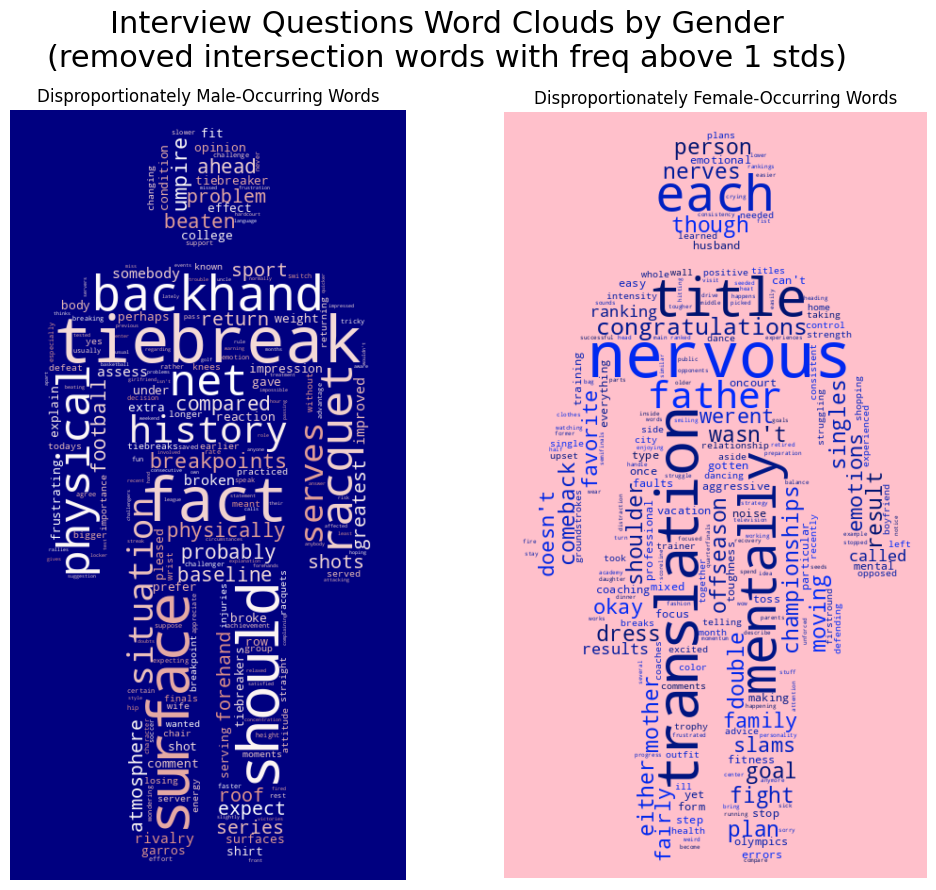

In [ ]:
interview_elements, interview_counters, interview_diff_lists = \
get_diff_words(male_words, female_words, remove_words, 1, 'Interview Questions')

-------------------------------------------------------------------
Male Frequency Mean: 36.10939590408562
Female Frequency Mean: 33.74871443263627
Male Frequency STD: 273.1239232342125
Female Frequency STD: 244.35025151324373
-------------------------------------------------------------------
Male Word Count: 36251
Female Word Count: 36251
-------------------------------------------------------------------


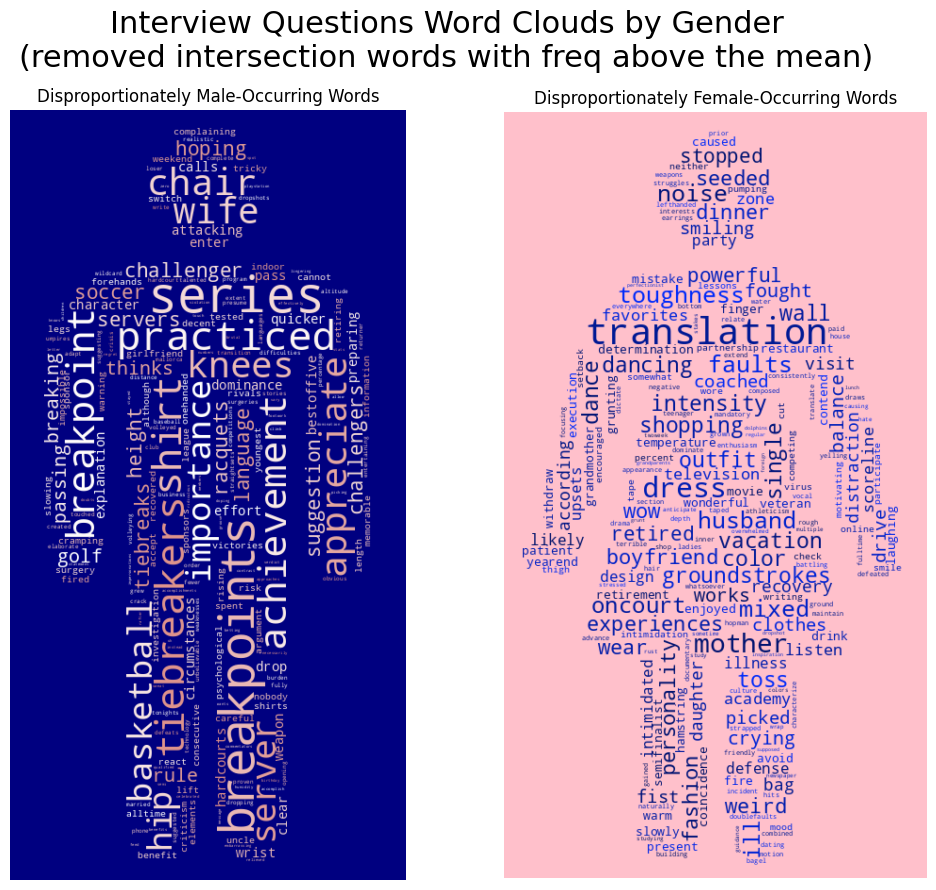

In [ ]:
interview_elements, interview_counters, interview_diff_lists = \
get_diff_words(male_words, female_words, remove_words, 0, 'Interview Questions')

-------------------------------------------------------------------
Male Frequency Mean: 36.10939590408562
Female Frequency Mean: 33.74871443263627
Male Frequency STD: 273.1239232342125
Female Frequency STD: 244.35025151324373
-------------------------------------------------------------------
Male Word Count: 3900
Female Word Count: 3900
-------------------------------------------------------------------


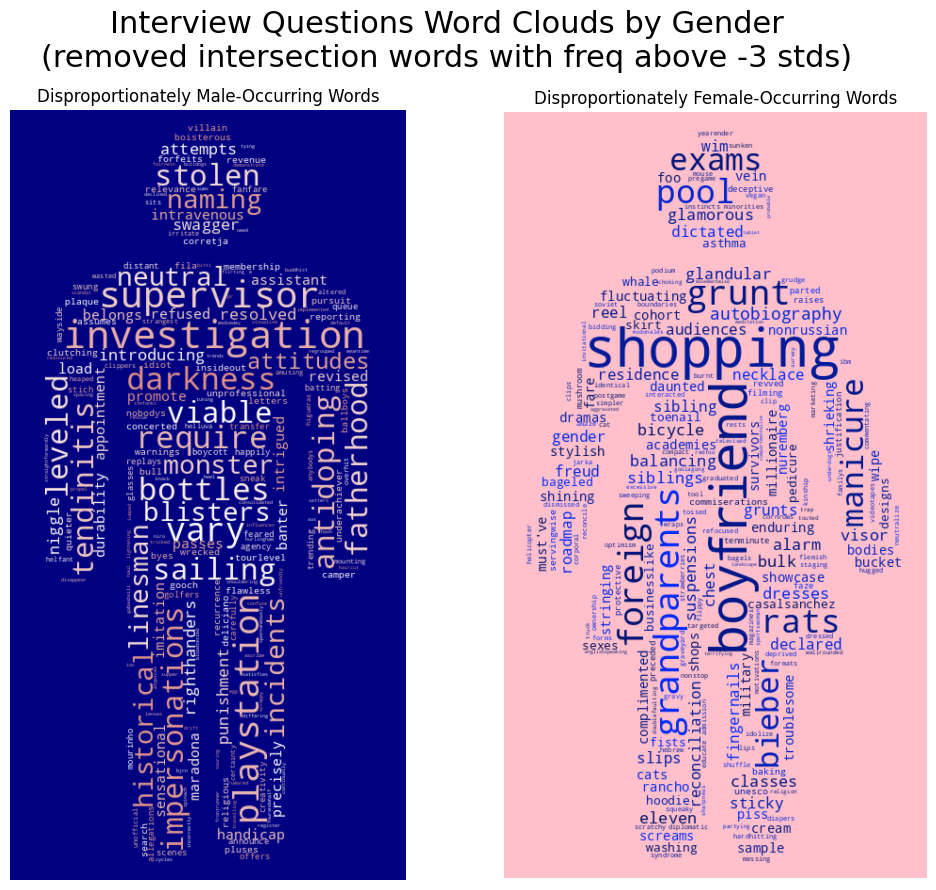

In [ ]:
interview_elements, interview_counters, interview_diff_lists = \
get_diff_words(male_words, female_words, remove_words, -3, 'Interview Questions')

### Mean Word Characteristic Scores by Gender

-------------------------------------------------------------------
Male Percentage of Words Included: 0.68
-------------------------------------------------------------------
Female Percentage of Words Included: 0.72
-------------------------------------------------------------------


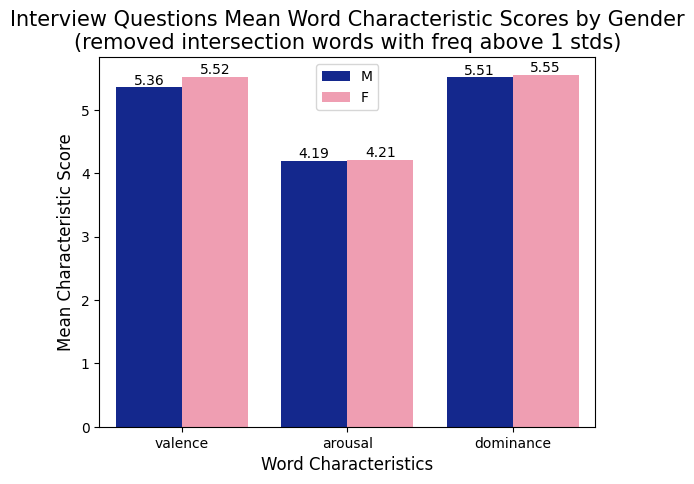

In [ ]:
# after removing the intersection of words appearing more than one standard
#    deviation from the mean in both the men's and women's questions, we take
#    the mean word characteristic score of the difference in counts to see how
#    words more commonly used to describe men deviate from those more commonly
#    used to describe women.
male_triple, female_triple = get_avg_vad(male_words, female_words, remove_words,
                                         1, 'Interview Questions')

-------------------------------------------------------------------
Male Percentage of Words Included: 0.68
-------------------------------------------------------------------
Female Percentage of Words Included: 0.7
-------------------------------------------------------------------


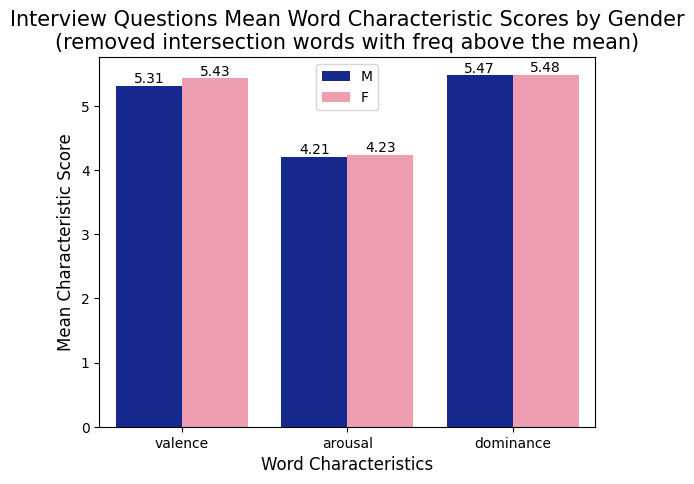

In [ ]:
male_triple, female_triple = get_avg_vad(male_words, female_words, remove_words,
                                         0, 'Interview Questions')

-------------------------------------------------------------------
Male Percentage of Words Included: 0.54
-------------------------------------------------------------------
Female Percentage of Words Included: 0.57
-------------------------------------------------------------------


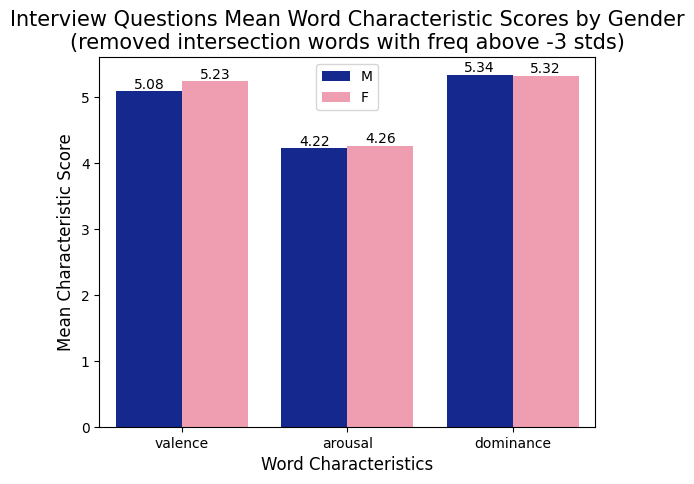

In [ ]:
male_triple, female_triple = get_avg_vad(male_words, female_words, remove_words,
                                         -3, 'Interview Questions')

### Number of Questions Per Ranking For Male and Female Players

In [ ]:
# Questions per rank and gender (top 100 players)
question_counts = questions_df_cleaned.groupby(by=["player", "ranking", "gender"])[['questions']].count().reset_index()
top_100 = question_counts[question_counts['ranking']<=100]
sns.lineplot(data=top_100, x='ranking', y='questions', hue='gender')

# Adding labels and title
plt.xlabel('Ranking')
plt.ylabel('Number of Questions')
plt.title('Number of Questions Per Ranking for Male and Female Players')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

### Number of Questions for Male and Female Players in the Top 5

In [ ]:
# Questions per rank and gender (top 100 players)
question_counts = questions_df_cleaned.groupby(by=["player", "ranking", "gender"])[['questions']].count().reset_index()
top_5 = question_counts[question_counts['ranking']<=5]
top_5 = top_5.groupby(['player', 'gender'])[['questions']].sum().reset_index()
sns.barplot(data=top_5, x='player', y='questions', hue='gender', hue_order=['M', 'F'])

# create custom colors array
colors = ["#001ba1", "#fc90ab"]
# set custom color palette
sns.set_palette(sns.color_palette(colors))

# Adding labels and title
plt.xlabel('Players')
plt.xticks(rotation=90)
plt.ylabel('Number of Questions')
plt.title('Number of Questions for Male and Female Players in the Top 5')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

## Commentaries Data

The commentary data contains 3962 pieces of live-text play-by-play commentaries, split evenly between men and women singles matches. It is a JSON file with three fields:

	- 'commentary': the actual text from the live updates. It describes the process of the game.
	- 'gender': 'F' indicates the update is from a women's match; 'M' means it is from men's game.
	- 'scoreline': the score when the text update is posted. * indicates the player who is serving at the moment.

While we used Sports Mole's commentaries for our study, ByTheMinute could be another source to gather similar data.



In [ ]:
commentaries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3962 entries, 0 to 3961
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   commentary  3962 non-null   object
 1   scoreline   3962 non-null   object
 2   gender      3962 non-null   object
dtypes: object(3)
memory usage: 93.0+ KB


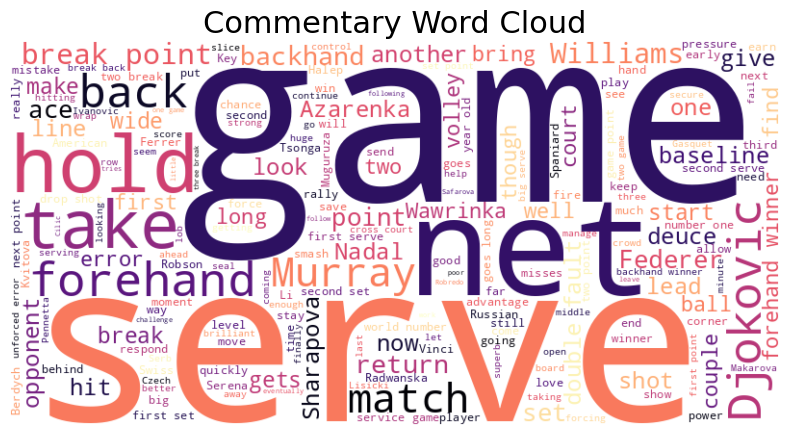

In [ ]:
# All Commentary Word Cloud
text = ' '.join(commentaries_df['commentary'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400,
                      colormap=sns.color_palette("magma", as_cmap=True),
                      background_color='white').generate(text)

# Display the generated word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Commentary Word Cloud', fontsize = 22)
plt.show()

### Gender Specific Commentary Data Word Clouds

In [ ]:
# Remove gender specific words, player names, case, and punctuation.

# filter into mens and womens data
commentary_m_df = commentaries_df[commentaries_df['gender'] == 'M']
commentary_f_df = commentaries_df[commentaries_df['gender'] == 'F']
male_text = ' '.join(commentary_m_df['commentary'])
female_text = ' '.join(commentary_f_df['commentary'])

# convert male and female words into lists
male_words = male_text.split()
female_words = female_text.split()

-------------------------------------------------------------------
Male Frequency Mean: 12.803529803529804
Female Frequency Mean: 13.87067458930444
Male Frequency STD: 61.06285304645142
Female Frequency STD: 66.2743341303204
-------------------------------------------------------------------
Male Word Count: 17306
Female Word Count: 17306
-------------------------------------------------------------------


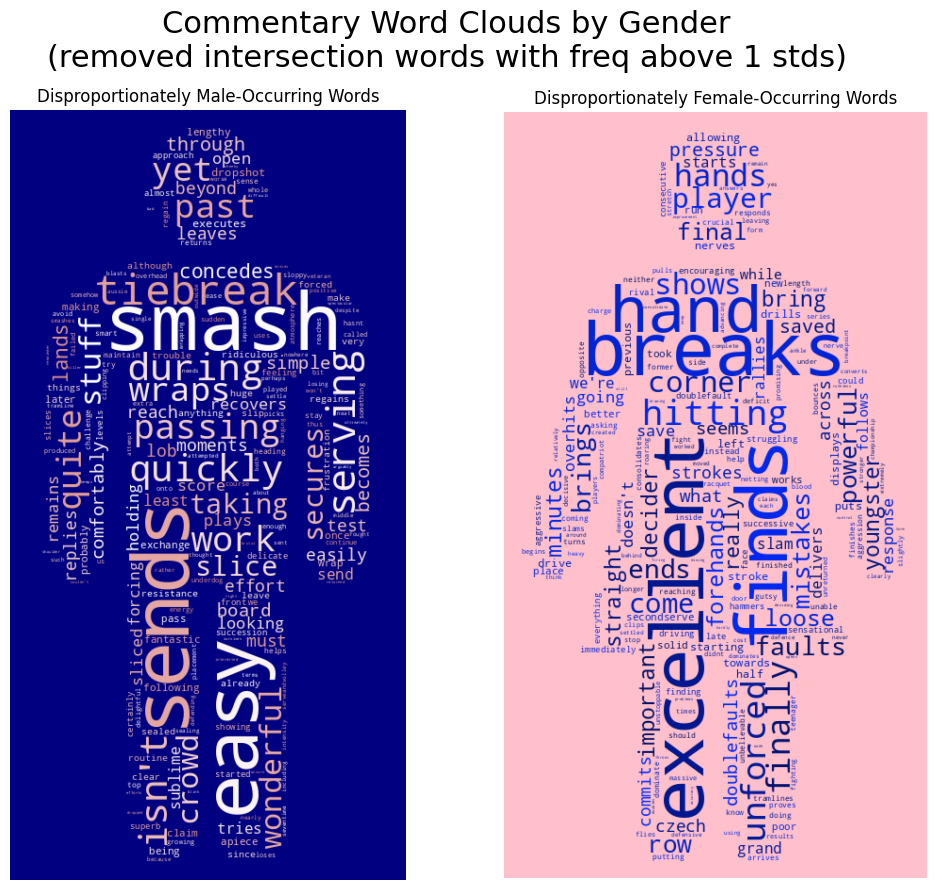

In [ ]:
comm_elements, comm_counters, comm__diff_lists = \
get_diff_words(male_words, female_words, remove_words, 1, 'Commentary')

-------------------------------------------------------------------
Male Frequency Mean: 12.803529803529804
Female Frequency Mean: 13.87067458930444
Male Frequency STD: 61.06285304645142
Female Frequency STD: 66.2743341303204
-------------------------------------------------------------------
Male Word Count: 7665
Female Word Count: 7665
-------------------------------------------------------------------


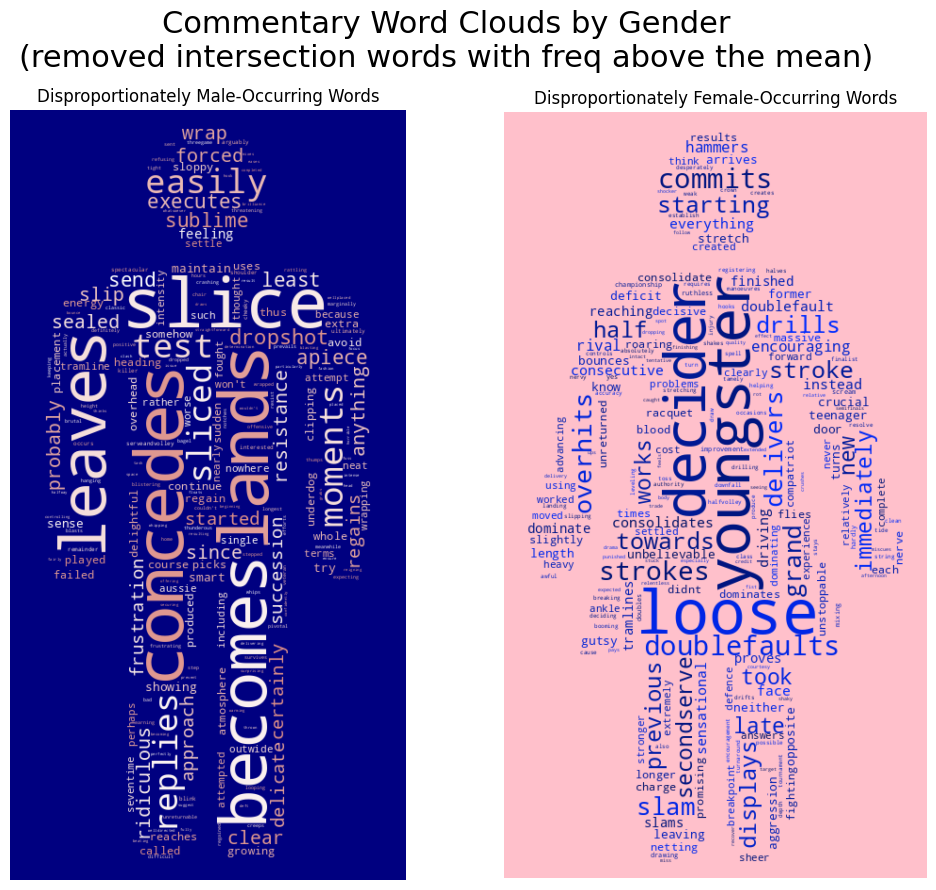

In [ ]:
comm_elements, comm_counters, comm__diff_lists = \
get_diff_words(male_words, female_words, remove_words, 0, 'Commentary')

-------------------------------------------------------------------
Male Frequency Mean: 12.803529803529804
Female Frequency Mean: 13.87067458930444
Male Frequency STD: 61.06285304645142
Female Frequency STD: 66.2743341303204
-------------------------------------------------------------------
Male Word Count: 1257
Female Word Count: 1257
-------------------------------------------------------------------


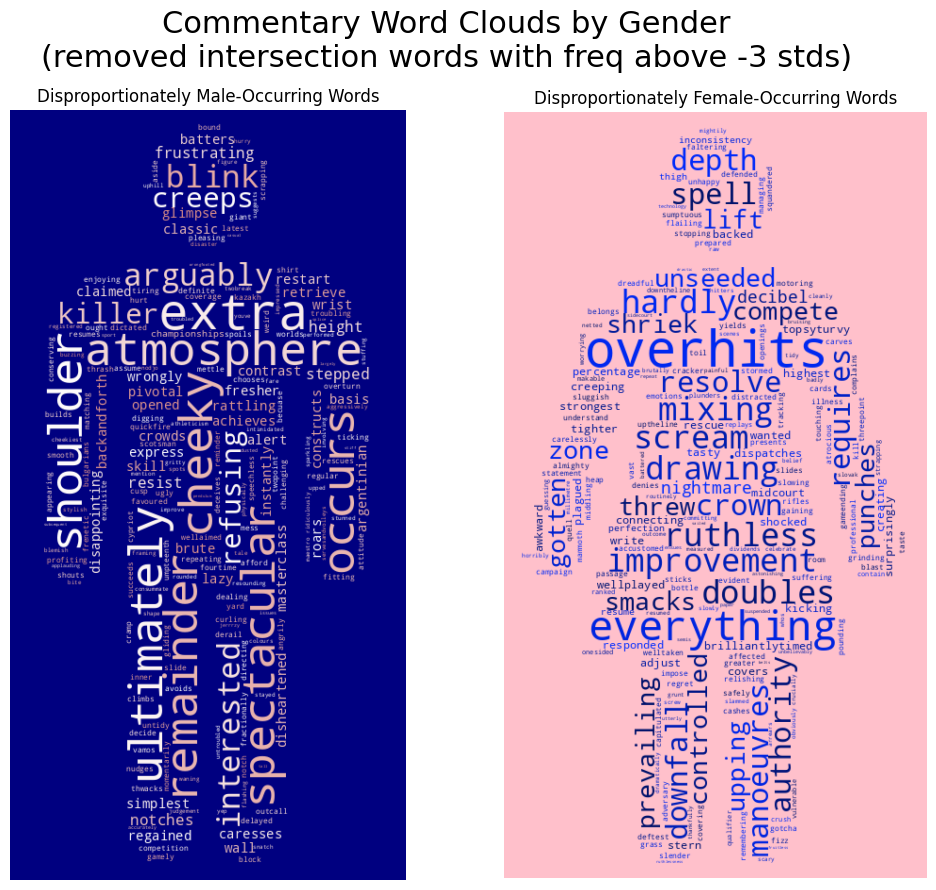

In [ ]:
comm_elements, comm_counters, comm__diff_lists = \
get_diff_words(male_words, female_words, remove_words, -3, 'Commentary')

### Mean Word Characteristic Scores by Gender

-------------------------------------------------------------------
Male Percentage of Words Included: 0.67
-------------------------------------------------------------------
Female Percentage of Words Included: 0.72
-------------------------------------------------------------------


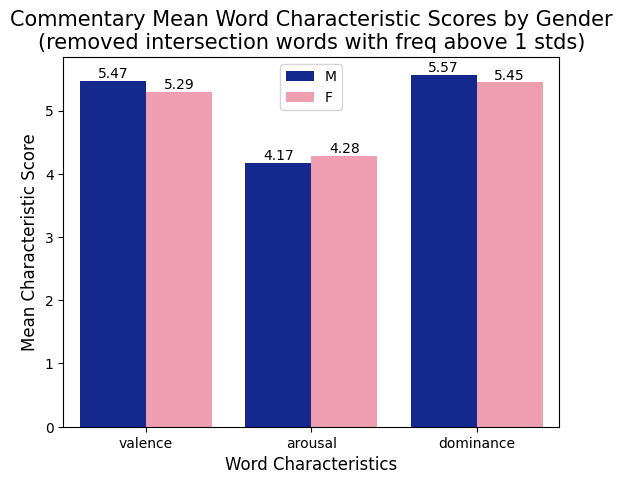

In [ ]:
# after removing the intersection of words appearing more than one standard
#    deviation from the mean in both the men's and women's commentary, we take
#    the mean word characteristic score of the difference in counts to see how
#    words more commonly used to describe men deviate from those more commonly
#    used to describe women.
male_triple, female_triple = get_avg_vad(male_words, female_words, remove_words,
                                         1, 'Commentary')

-------------------------------------------------------------------
Male Percentage of Words Included: 0.68
-------------------------------------------------------------------
Female Percentage of Words Included: 0.71
-------------------------------------------------------------------


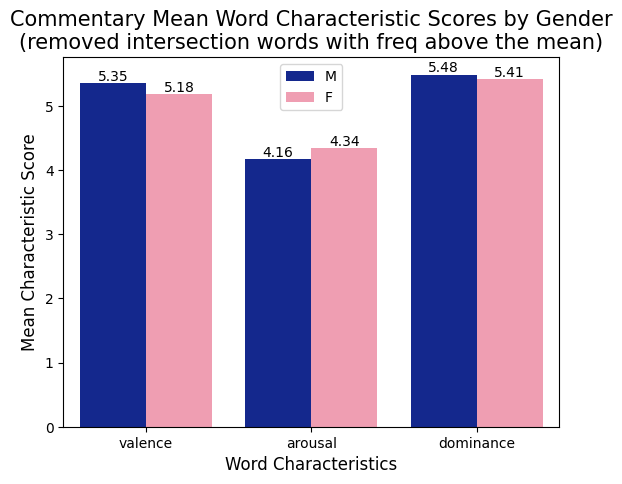

In [ ]:
male_triple, female_triple = get_avg_vad(male_words, female_words, remove_words,
                                         0, 'Commentary')

-------------------------------------------------------------------
Male Percentage of Words Included: 0.65
-------------------------------------------------------------------
Female Percentage of Words Included: 0.67
-------------------------------------------------------------------


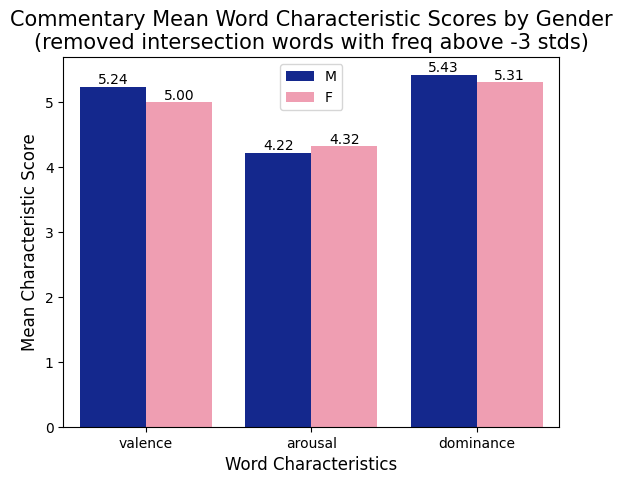

In [ ]:
male_triple, female_triple = get_avg_vad(male_words, female_words, remove_words,
                                         -3, 'Commentary')

### Number of Commentaries for Male and Female Players

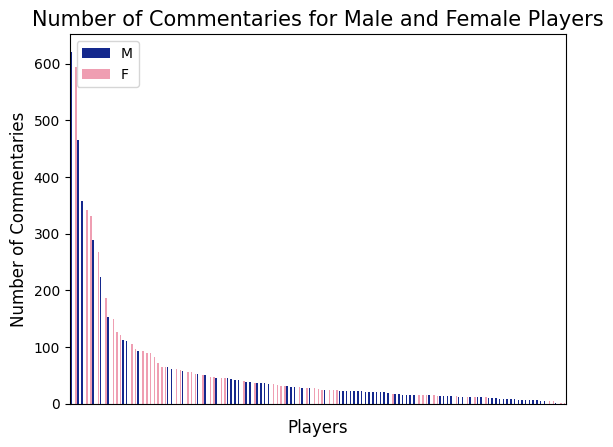

In [ ]:
# combine players into a single column to explore how interviews are divided up

# get two players columns
commentaries_df['player1'] = commentaries_df['scoreline'].apply(lambda x: x.split()[0].replace('*', ''))
commentaries_df['player2'] = commentaries_df['scoreline'].apply(lambda x: x.split()[len(x.split())-1].replace('*', ''))

# concat the dataframe with itself with one combined player column
df1 = commentaries_df
df1 = df1.drop(columns='player2')
df1 = df1.rename(columns={'player1':'player'})
df2 = commentaries_df
df2 = df2.drop(columns='player1')
df2 = df2.rename(columns={'player2':'player'})
frames = [df1, df2]
combined_commentaries_df = pd.concat(frames)
player_comm_feq_df = combined_commentaries_df.groupby(by=["player", "gender"])[['commentary']].count().reset_index()
player_comm_feq_df = player_comm_feq_df.sort_values(by='commentary', ascending=False)

# Commentaries per player by gender

# create custom colors array
colors = ["#001ba1", "#fc90ab"]
# set custom color palette
sns.set_palette(sns.color_palette(colors))

g1 = sns.barplot(data=player_comm_feq_df, x='player', y='commentary',
                 hue='gender', hue_order=['M', 'F'])
g1.tick_params(bottom=False)
g1.set(xticklabels=[])

# Adding labels and title
plt.xlabel('Players', fontsize=12)
plt.ylabel('Number of Commentaries', fontsize=12)
plt.title('Number of Commentaries for Male and Female Players', fontsize = 15)

# Adding a legend
plt.legend()

# Display the plot
plt.show()

### Players with the Most Commentaries

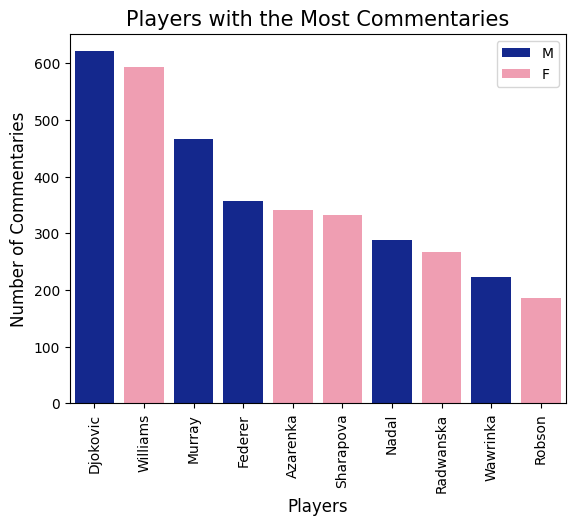

In [ ]:
# The players with the most commentaries (10 most)
top_player_comm_freq_df = player_comm_feq_df[0:10]

# create custom colors array
colors = ["#001ba1", "#fc90ab"]
# set custom color palette
sns.set_palette(sns.color_palette(colors))

g1 = sns.barplot(data=top_player_comm_freq_df, x='player', y='commentary', hue='gender',
                 dodge=False, hue_order=['M', 'F'])

# Adding labels and title
plt.xlabel('Players', fontsize=12)
plt.xticks(rotation=90)
plt.ylabel('Number of Commentaries', fontsize=12)
plt.title('Players with the Most Commentaries', fontsize=15)

# Adding a legend
plt.legend()

# Display the plot
plt.show()

### Comentary Word Count Distribution by Gender

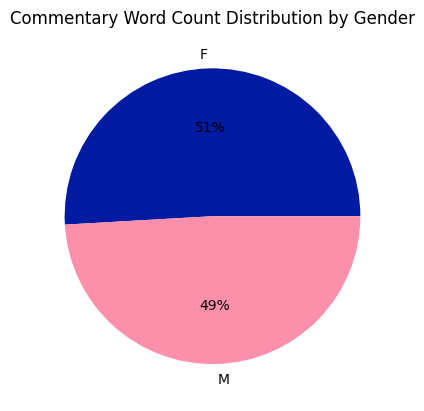

In [ ]:
# explore how the number of words are divded up among male/female commentaries
commentaries_df[['commentary', 'gender']]
commentaries_df['word_length'] = commentaries_df['commentary'].apply(lambda x: len(x))
gender_comm_word_counts_df = commentaries_df.groupby(by=['gender'])[['word_length']].sum().reset_index()

# plotting data on chart

# create custom colors array
colors = ["#001ba1", "#fc90ab"]
# set custom color palette
sns.set_palette(sns.color_palette(colors))

plt.pie(data=gender_comm_word_counts_df, x= 'word_length', labels='gender',
        autopct='%.0f%%')

plt.title('Commentary Word Count Distribution by Gender')

# displaying chart
plt.show()

## Transcripts Data

The dataset provide the full transcript (i.e. both questions and player responses), in the format of a JSON file:

	>>> import json
	>>> with open("transcripts_matchinfo.json", "r") as f:
	...		interviews = json.load(f)

	The following is an example for one transcript, with each field explained:

	>>> interview = interviews['0']
	0: {
		'QandA': ...  
			# Interview transcripts in the format of a list of question answer pairs.   
		'date': '2015-06-21',  # date the match is played
		'gender': 'M', # 'F' indicates women's singles match, 'M' indicates men's.
		'opponent': 'Kevin Anderson', # opponent in the match
			(available only if the opponent has at least one interview recorded in our dataset.)
  		'player': 'Andy Murray', # player being interviewed
  		'ranking': 3, # ranking of the player
  		'result': 1,  # 1 indicates the player being interviewed has won the match; 0 otherwise.
    		'stage': 'The Final', # stage of the tournament
  		'tournament': 'AEGON CHAMPIONSHIPS' # tournament name
		'tournament_type': 'ATP500', # type of the tournament, indicating tournament prestige.
	}

Note that:

- These questions and answers are transcribed exactly the way the journalists and the players put it; they are not further edited for grammatical correctness. There are, although relatively rarely, questions that are marked as (Off microphone.), (Indiscernible) or even (Translated from X) where X is a language other than English.
- Information about which journalist asked which question is not available.
- This transcript data does not contain all singles press conference transcripts available at ASAP sports as we only included transcripts that we could find corresponding match information for. In addition, since transcripts data and match results are matched by date and player last name, and we did not manually check for every match, it is possible to have a few matching errors.



In [ ]:
transcripts_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6467 entries, 0 to 6466
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   QandA            6467 non-null   object        
 1   ranking          6466 non-null   float64       
 2   tournament_type  6467 non-null   object        
 3   gender           6467 non-null   object        
 4   tournament       6467 non-null   object        
 5   player           6467 non-null   object        
 6   result           6467 non-null   int64         
 7   date             6467 non-null   datetime64[ns]
 8   stage            6467 non-null   object        
 9   opponent         6467 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(7)
memory usage: 555.8+ KB


### Interview Data by Tournament

In [ ]:
tournaments_df = transcripts_df.groupby(by=['tournament', 'gender'])[['QandA']].count().reset_index()
tournaments_df = tournaments_df.sort_values(by='QandA', ascending=False)

# Tournament Frequencies
g1 = sns.barplot(data=tournaments_df, x='tournament', y='QandA', hue='gender',
                 hue_order=['M', 'F'])
g1.tick_params(bottom=False)
g1.set(xticklabels=[])

# Adding labels and title
plt.xlabel('Tournaments', fontsize=12)
plt.ylabel('Number of Interviews', fontsize=12)
plt.title('Interview Data by Tournament', fontsize = 15)

# Display the plot
plt.show()

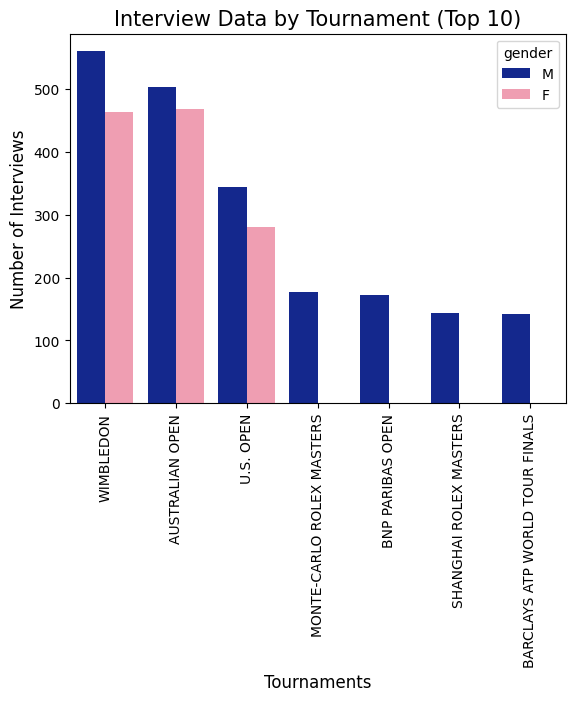

In [ ]:
# The players with the most commentaries (10 most)
tournaments_df = tournaments_df[0:10]

# create custom colors array
colors = ["#001ba1", "#fc90ab"]
# set custom color palette
sns.set_palette(sns.color_palette(colors))

g1 = sns.barplot(data=tournaments_df, x='tournament', y='QandA',
                 hue='gender', hue_order=['M', 'F'])

# Adding labels and title
plt.xlabel('Tournaments', fontsize=12)
plt.xticks(rotation=90)
plt.ylabel('Number of Interviews', fontsize=12)
plt.title('Interview Data by Tournament (Top 10)', fontsize = 15)

# Display the plot
plt.show()

### Get answers in terms of gender as two lists of words

In [ ]:
male_transcripts_df = transcripts_df[transcripts_df['gender'] == 'M']
female_transcripts_df = transcripts_df[transcripts_df['gender'] == 'F']

male_answers = []
for interview in male_transcripts_df['QandA'].to_list():
  for qna in interview:
    male_answers.append(qna[1])

female_answers = []
for interview in female_transcripts_df['QandA'].to_list():
  for qna in interview:
    female_answers.append(qna[1])

split_words = [words.split() for words in male_answers]
male_words = [word for words in split_words for word in words]

split_words = [words.split() for words in female_words]
female_words = [word for words in split_words for word in words]

### Interview Answers Word Clouds by Gender

-------------------------------------------------------------------
Male Frequency Mean: 112.03877585056705
Female Frequency Mean: 13.87067458930444
Male Frequency STD: 1029.2522722381398
Female Frequency STD: 66.2743341303204
-------------------------------------------------------------------
Male Word Count: 21889
Female Word Count: 21889
-------------------------------------------------------------------


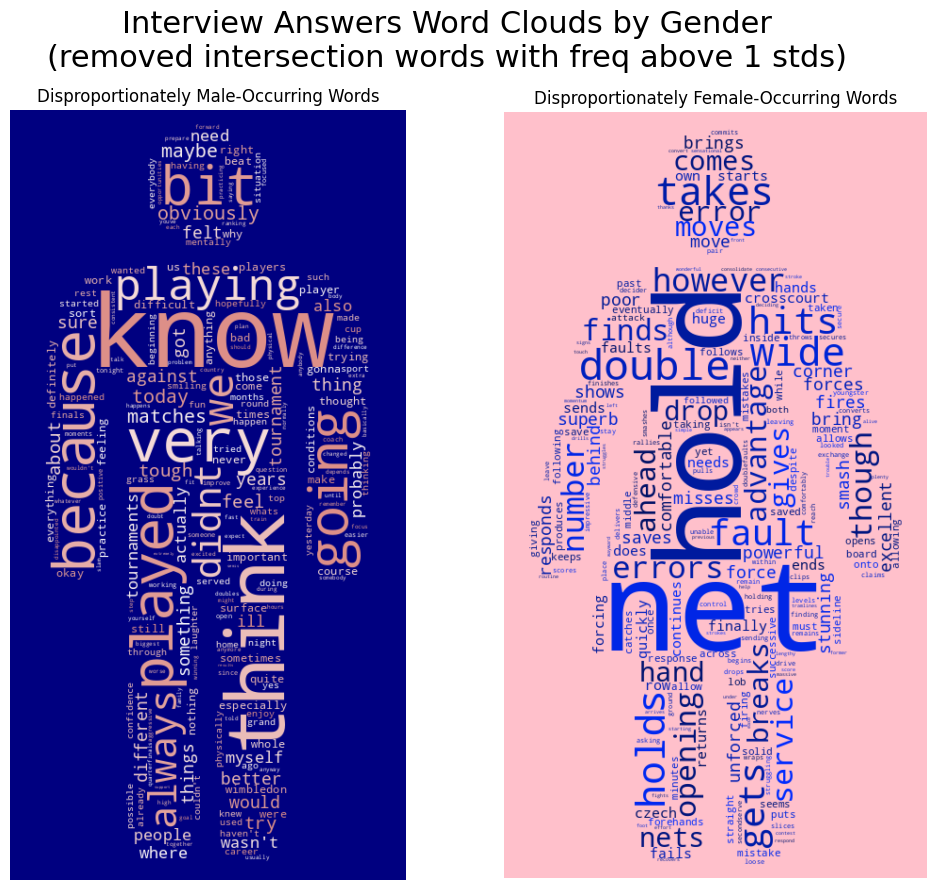

In [ ]:
comm_elements, comm_counters, comm__diff_lists = \
get_diff_words(male_words, female_words, remove_words, 1, 'Interview Answers')

-------------------------------------------------------------------
Male Frequency Mean: 112.03877585056705
Female Frequency Mean: 13.87067458930444
Male Frequency STD: 1029.2522722381398
Female Frequency STD: 66.2743341303204
-------------------------------------------------------------------
Male Word Count: 10927
Female Word Count: 10927
-------------------------------------------------------------------


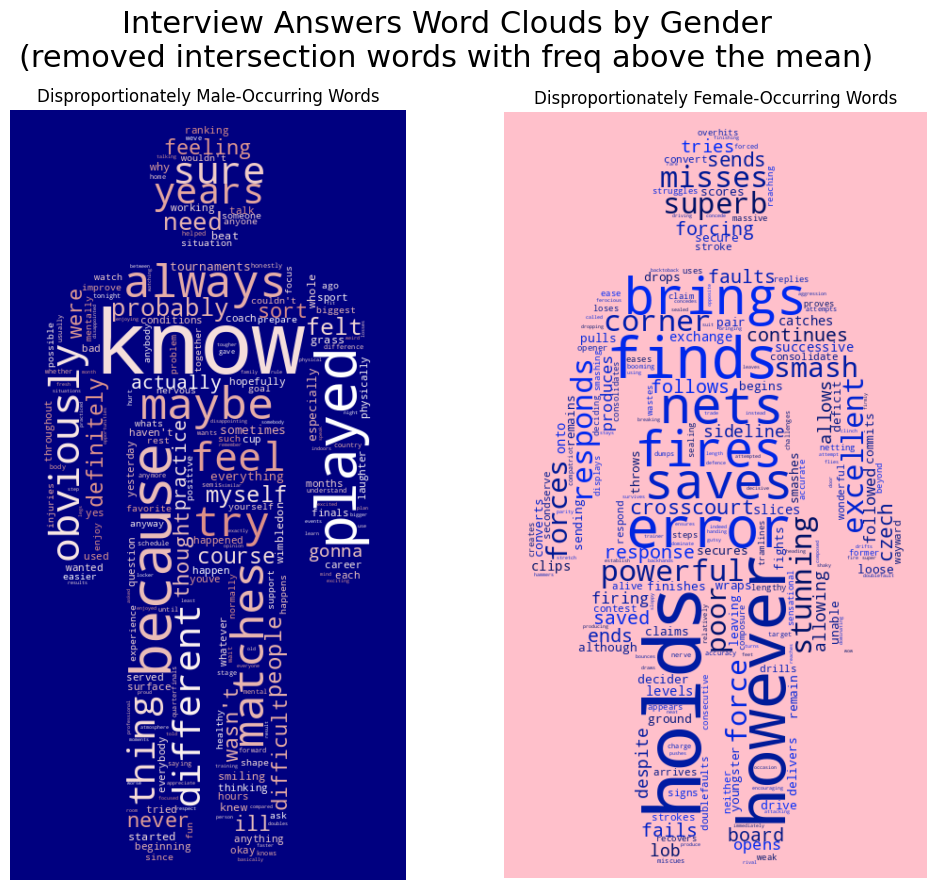

In [ ]:
comm_elements, comm_counters, comm__diff_lists = \
get_diff_words(male_words, female_words, remove_words, 0, 'Interview Answers')

-------------------------------------------------------------------
Male Frequency Mean: 112.03877585056705
Female Frequency Mean: 13.87067458930444
Male Frequency STD: 1029.2522722381398
Female Frequency STD: 66.2743341303204
-------------------------------------------------------------------
Male Word Count: 1355
Female Word Count: 1355
-------------------------------------------------------------------


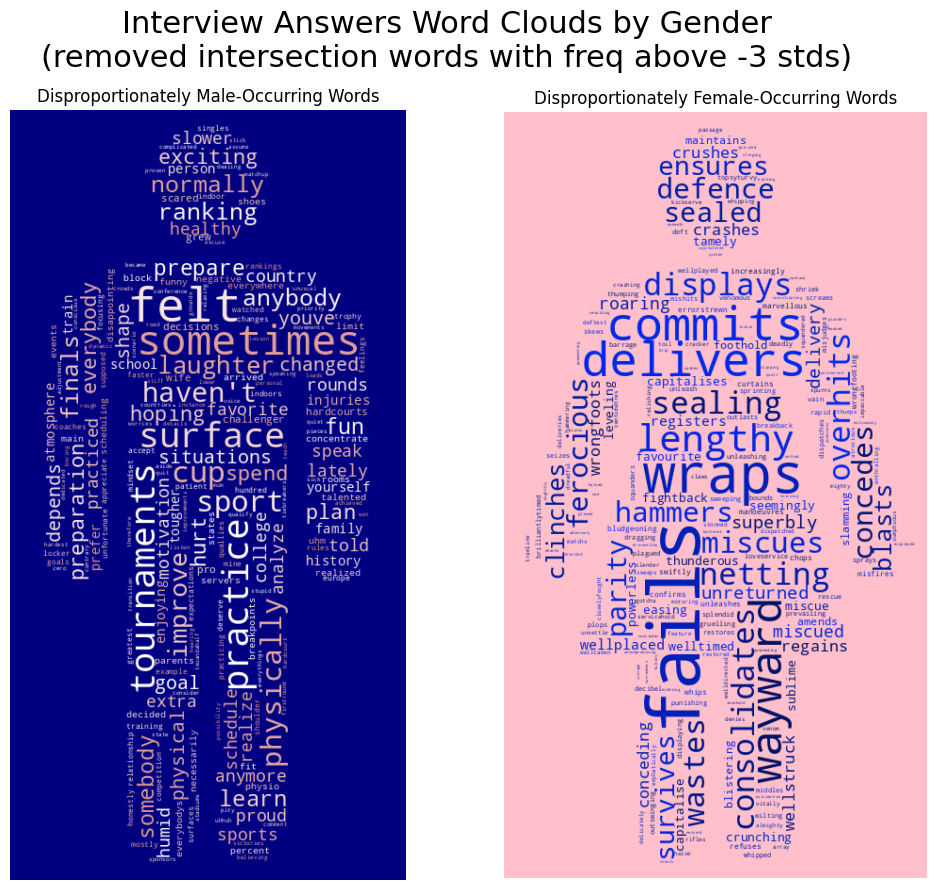

In [ ]:
comm_elements, comm_counters, comm__diff_lists = \
get_diff_words(male_words, female_words, remove_words, -3, 'Interview Answers')

### Interview Answers Word Characteristic Scores by Gender

In [ ]:
# after removing the intersection of words appearing more than one standard
#    deviation from the mean in both the men's and women's commentary, we take
#    the mean word characteristic score of the difference in counts to see how
#    words more commonly used to describe men deviate from those more commonly
#    used to describe women.
male_triple, female_triple = get_avg_vad(male_words, female_words, remove_words,
                                         1, 'Interview Answers')

-------------------------------------------------------------------
Male Percentage of Words Included: 0.64
-------------------------------------------------------------------
Female Percentage of Words Included: 0.8
-------------------------------------------------------------------


-------------------------------------------------------------------
Male Percentage of Words Included: 0.68
-------------------------------------------------------------------
Female Percentage of Words Included: 0.76
-------------------------------------------------------------------


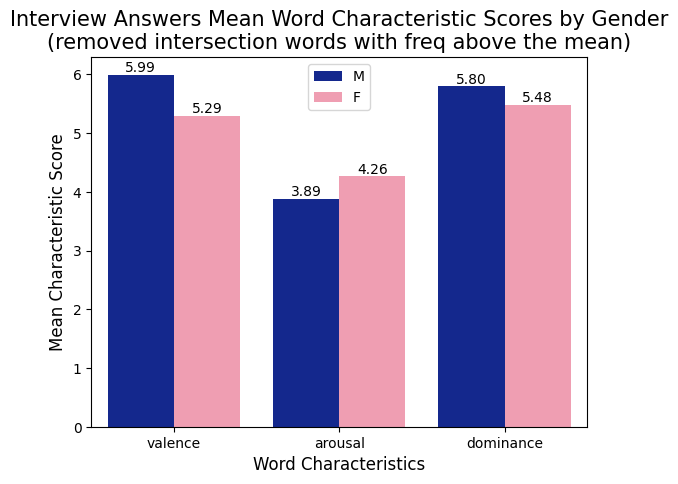

In [ ]:
male_triple, female_triple = get_avg_vad(male_words, female_words, remove_words,
                                         0, 'Interview Answers')

-------------------------------------------------------------------
Male Percentage of Words Included: 0.73
-------------------------------------------------------------------
Female Percentage of Words Included: 0.61
-------------------------------------------------------------------


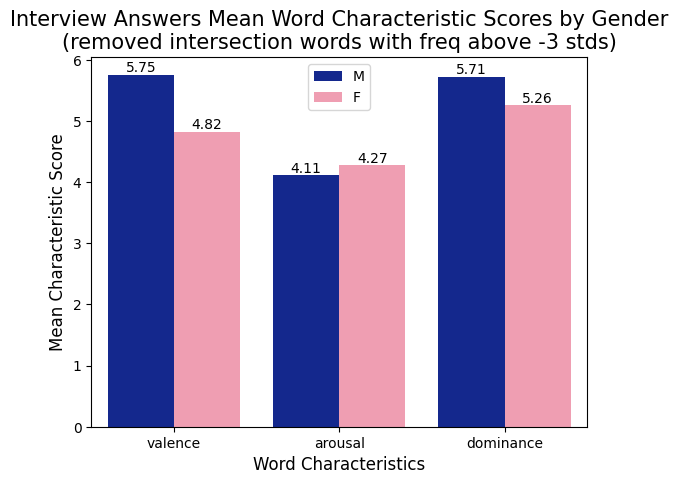

In [ ]:
male_triple, female_triple = get_avg_vad(male_words, female_words, remove_words,
                                         -3, 'Interview Answers')